# CUPED for Starters: Enhancing Controlled Experiments with Pre-Experiment Data

### Intro

In this article, I will briefly explain the randomized controlled experiments and why modern companies use them to make data-driven decisions. Then, I will introduce you to a CUPED procedure that improves the sensitivity of these experiments. After that, I will show you why it works in theory and practice. We will simulate an ordinary A/B test and compare results with the CUPED-adjusted procedure. We will see empirically that CUPED allows the detection of more minor effects on the same sample size.

### What are Controlled Experiments, and why do we need them

Controlled experiments, a cornerstone of data science, are systematic and controlled approaches used to investigate the impact of specific changes, interventions, or treatments on a target system. In these experiments, researchers manipulate one or more variables while keeping other factors constant, creating a controlled environment to accurately observe and measure the effects. The goal is to establish a causal relationship between the manipulated variables and the observed outcomes. Controlled experiments provide valuable insights into cause-and-effect relationships, enabling data scientists, researchers, and decision-makers to make informed choices based on empirical evidence rather than mere correlations or assumptions.

Usually, people encounter controlled experiments in the form of A/B tests. In an A/B test, a single variable (such as a webpage design, machine learning algorithm, or pricing plan) is changed between two versions: A (the control) and B (the variant). The goal of an A/B test is to compare the performance of these two versions to determine which one performs better in a specific metric (e.g., click-through rates, revenue). A/B tests are commonly used in marketing and web optimization to make data-driven decisions about changes to user interfaces or marketing material.

To perform an A/B test, you have to gather some data. The amount of data you need is directly connected to the variance of the metric you want to compare between two groups. The more the chosen metric fluctuates naturally, the more data you need to spot the difference between the two groups. The more data you need, the longer you wait until you get the results. And time is money! That is why Microsoft researchers developed a [CUPED technique](https://dl.acm.org/doi/10.1145/2433396.2433413). This statistical trick helps you to decrease the variance of the tested metric. With lower variance, you need a smaller sample size to spot the same difference, or you can spot a smaller one with the same sample size.

### What is CUPED and how it works?

CUPED stands for "Controlled-Experiment using Pre-Experiment Data." The idea is simple: modify the metric of interest in a way that its expectation does not change while variance decreases. The exciting part is how to do so! 

Suppose you want to test if there is a difference in metric $Y$. In a usual A/B test, you would calculate mean value of the metric in control group $\bar{Y}_{A}$ and then compare it with mean value of the metric in test group $\bar{Y}_{B}$.

Researchers suggested this transformation:
$$
\hat{Y}_{CUPED} = \bar{Y} - \theta(\bar{X} - E(X))
$$
Where $X$ is a random variable correlated with $Y$ but not affected by the A/B test, and $\theta$ is some arbitrary (for now) constant.

A great candidate for $X$ is the same metric $Y$ but before the start of the test. Hence, there is "pre-experiment" in the name of the method.

But how does this help to decrease variance and not mess up the results? The theoretical explanation in the paper needed to be more specific for me. So, let us derive results by ourselves.

First of all, $\hat{Y}_{CUPED}$ is an unbiased estimator of $E(Y)$:

![CUPED Proof Part 1](./input/CUPED_proof_1.png)

Secondly, let us derive the $Var(\hat{Y}_{CUPED})$:

![CUPED Proof Part 1](./input/CUPED_proof_2.png)

Now, let us find a value of $\theta$ that minimizes this variance:

![CUPED Proof Part 1](./input/CUPED_proof_3.png)

With such $\theta$ we will have $Var(\hat{Y}_{CUPED})$:

![CUPED Proof Part 1](./input/CUPED_proof_4.png)

Cool! Variance is $(1 - \rho^2)$ times smaller that the variance of our initial estimate $Var(\bar{Y})$!
The higher the correlation between $X$ and $Y$, the higher the variance reduction power.

### How to use CUPED in practice?

Enough theory for today! Let us apply this technique to a real-world problem.

Suppose we are working for some food delivery service (like Uber Eats, for example). Each restaurant has a display of meals users can order. There are so many meals that we want to recommend something to the user to speed up the choosing process. The faster he places an order, the quicker he gets his food, and the faster he becomes happy!

We already have a recommendation engine A, but the ML team has introduced another recommendation engine B. Now we want to understand which engine is better. We need an A/B test! Let us randomly expose each user to either engine A or engine B. Now, we need a metric to compare between two groups. Money is the best metric as each business tries to maximize its profits. So, let us measure the commission revenue from users within two weeks.

I have prepared a simple dataset that represents this A/B test. Each row represents a user.
Here is an explanation of what each column means:
1. `group` - is either `test` or `control`; if it is `test`, then the user is in the group with new recommendation engine
2. `user_id` - a unique identifier of a user
3. `commission_revenue_pre` - commission revenue company got from orders of this user in a pre-experiment period
4. `commission_revenue_exp` - commission revenue company for from order of this user during an experiment period

The only thing different from real life here is that I know exactly how a new engine impacts the metric. If a user is exposed to engine B, his `commission_revenue_exp` will increase by 2%.

Let us do the usual A/B test comparing average `commission_revenue_exp` for two engines using a t-test (assume that all assumptions hold, and we can use it here). 

First of all, we need to import some useful libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

Now, let's load the data:

In [2]:
exp_data = pd.read_csv('./input/commission_revenue.csv')

exp_data.sample(10)

,group,user_id,commission_revenue_pre,commission_revenue_exp
393,test,85d2c688-5d8b-4030-91d9-0691f47dfa8a,130.753108,142.429411
1323,test,01becda6-86e4-471f-9b27-3c578c322829,139.153649,147.180470
134,test,3efacf74-9693-468d-b78e-7bb11b6b37ca,115.448414,104.440638
147,control,25d796c4-3962-4c60-b376-de65d37f36ff,101.103246,102.259490
224,control,1f5570b2-9d7f-4043-aec4-66140d01350c,NaN,71.767811
657,test,54874c33-0f73-481b-b3c2-5da390106f67,58.588021,64.410593
287,test,e94bafca-d719-462c-9ab6-cfde609de972,115.613434,106.507325
939,control,9ddd3711-7d9f-475a-8a5d-b758b929a1fd,83.859978,89.201692
1131,test,b07ac058-4ac8-4858-9152-2538d980ad9a,83.948000,70.460465
1821,control,46476122-3869-433f-a785-5df615cde0a7,159.957868,136.278364


In [3]:
exp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   group                   2000 non-null   object 
 1   user_id                 2000 non-null   object 
 2   commission_revenue_pre  1963 non-null   float64
 3   commission_revenue_exp  2000 non-null   float64
dtypes: float64(2), object(2)
memory usage: 62.6+ KB


Let's have a look at the average commission revenue during the experiment in two groups:

In [4]:
commission_revenue_exp_test_avg = exp_data[exp_data['group'] == 'test']['commission_revenue_exp'].mean()
commission_revenue_exp_control_avg = exp_data[exp_data['group'] == 'control']['commission_revenue_exp'].mean()

print(f'In a test group (new engine B), the metric is on average equal to {commission_revenue_exp_test_avg:0.2f}')
print(f'In a control group (old engine A), the metric is on average equal to {commission_revenue_exp_control_avg:0.2f}')
print(f'Relative increase is equal to {100.0 * (commission_revenue_exp_test_avg / commission_revenue_exp_control_avg - 1):0.1f}%')

In a test group (new engine B), the metric is on average equal to 101.73
In a control group (old engine A), the metric is on average equal to 99.24
Relative increase is equal to 2.5%


We already know that engine B increases metric by two percent because data was synthetically created. But in the real world, we need to run some statistical procedures to understand whether this increase is statistically significant. Maybe we were just lucky to get this result.

Using [Student's t-tets](https://en.wikipedia.org/wiki/Student%27s_t-test), we can test a hypothesis of zero difference in the averages of two groups. Let's use $alpha = 0.05$ for this test, meaning that we will test this hypothesis at a 5% significance level.

In [5]:
stats.ttest_ind(
    exp_data[exp_data['group'] == 'test']['commission_revenue_exp'], 
    exp_data[exp_data['group'] == 'control']['commission_revenue_exp']
)

Ttest_indResult(statistic=1.8021000484396446, pvalue=0.0716803352566017)

We got a p-value near $0.07$, which is definitely greater than $0.05 / 2 = 0.025$. Then, we cannot reject the null hypothesis of equal averages. This means we did not see any statistically significant improvement in the target metric from using the new recommendation engine B in production.

You may ask how this happened, if we know there must be an increase of 2%. When we have an infinite number of observations, sample means are equal to population means (because of [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)). Unfortunately, we have to operate with finite samples in our experiments. This introduces some variation in our estimates of the parameters of distributions. So, we always have some margin of error in our estimates. And the smaller the sample size, the bigger the margin or error. When the sample size is not big enough, we cannot say that the difference between two samples is not present because of random associated with finite sample size.

As discussed earlier, CUPED can help us improve sensitivity by decreasing the metric variance we compare between two groups. Ultimately, this means we can detect smaller parameter changes for the same sample size. Let's make a CUPED transformation using `commission_revenue_pre`. We can do so because `commission_revenue_pre` is highly likely to be correlated with `commission_revenue_exp` because this is the same metric of the same users but in different time periods. But `commission_revenue_pre` is not affected by the new engine B because engine B was introduced after the metric was calculated. Hence, `commission_revenue_pre` is a fantastic candidate for `X`.

A closer look at the data shows that not all users have a `commission_revenue_pre` defined. This is absolutely normal in the real world - some users do not have pre-experiment data because they were not users before the experiment! We need to understand what to do with "newbies". Here, we can rely on the experience of Booking.com on how to handle missing data. They [suggest](https://booking.ai/how-booking-com-increases-the-power-of-online-experiments-with-cuped-995d186fff1d) to do nothing to the metric in case pre-experiment data is not available. The idea behind this trick is straightforward. When there is a missing value, you want to fill it with an average derived from the samples where this value is not missing. So, you will plug $\bar{X}$ into the $X_i$ in CUPED transformation, and it will be canceled out with $E(X)$ with a big enough sample size!

Now, let's calculate $\theta$, handle missing values, and make sure that the CUPED transformation yields an unbiased estimate:

In [6]:
not_null_pre = ~exp_data['commission_revenue_pre'].isna()

cov_X_Y = np.cov(exp_data[not_null_pre]['commission_revenue_pre'], 
                 exp_data[not_null_pre]['commission_revenue_exp'],
                 ddof=1)[0, 1]

var_X = np.var(exp_data[not_null_pre]['commission_revenue_pre'], ddof=1)

corr_X_Y = np.corrcoef([exp_data[not_null_pre]['commission_revenue_pre'], 
                        exp_data[not_null_pre]['commission_revenue_exp']])[0,1]

theta = cov_X_Y / var_X

theta

0.8818300441315146

In [7]:
exp_data['commission_revenue_exp_cuped'] = np.where(
    not_null_pre,
    exp_data['commission_revenue_exp'] - theta * (
        exp_data['commission_revenue_pre'] - exp_data['commission_revenue_pre'].mean()
    ),
    exp_data['commission_revenue_exp']
)

In [8]:
commission_revenue_exp_cuped_test_avg = exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'].mean()
commission_revenue_exp_cuped_control_avg = exp_data[exp_data['group'] == 'control']['commission_revenue_exp_cuped'].mean()

print(f'In a test group (new engine B), the CUPED-metric is on average equal to {commission_revenue_exp_cuped_test_avg:0.2f}')
print(f'In a control group (old engine A), the CUPED_metric is on average equal to {commission_revenue_exp_cuped_control_avg:0.2f}')
print(f'Relative increase is equal to {100.0 * (commission_revenue_exp_cuped_test_avg / commission_revenue_exp_cuped_control_avg - 1):0.1f}%')

In a test group (new engine B), the CUPED-metric is on average equal to 101.69
In a control group (old engine A), the CUPED_metric is on average equal to 99.28
Relative increase is equal to 2.4%


In the test group, we got 101.73 before transformation and 101.69 after. A 0.04 absolute difference appears because $\bar{X} = E(X)$ only in the limit where we have an infinite number of samples. In our real-world case, the sample size is finite. Hence, we have some differences.

Somewhere above, we have proved that the variance of sample average CUPED-metric is $(1-\rho^2)$ times smaller, where $\rho$ is a correlation between $Y$ and $X$. So, we must see this in the data also.

In [9]:
var_Y = np.std(exp_data[exp_data['group'] == 'test']['commission_revenue_exp'])**2
var_Y_bar = var_Y / len(exp_data[exp_data['group'] == 'test'])

var_Y_CUPED = np.std(exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'])**2
var_Y_CUPED_bar = var_Y_CUPED / len(exp_data[exp_data['group'] == 'test'])

print(f'Var(Y_bar) = {var_Y_bar:0.2f}')
print(f'Var(Y_CUPED_bar) = {var_Y_CUPED_bar:0.2f}')
print(f'(1 - rho^2) = {1 - corr_X_Y**2:0.3f}')
print(f'Var(Y_CUPED_bar) / Var(Y_bar) = {var_Y_CUPED_bar / var_Y_bar:0.3f}')

Var(Y_bar) = 1.00
Var(Y_CUPED_bar) = 0.21
(1 - rho^2) = 0.210
Var(Y_CUPED_bar) / Var(Y_bar) = 0.210


Amazing, empirics supports theory!

A decrease in variance can also be visualized easily. We assume that the metric is normally distributed. Metric with lower variance would have a "slimmer" probability mass function with a "taller" peak:

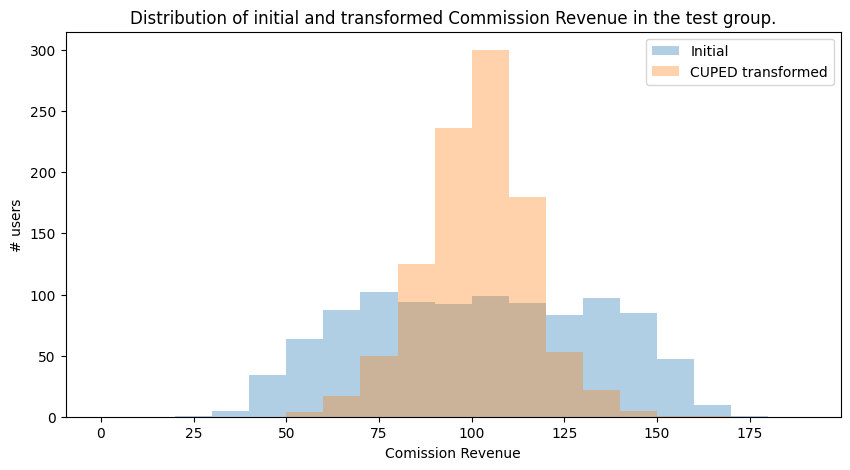

In [10]:
plt.figure(figsize=(10, 5))

plt.hist(exp_data[exp_data['group'] == 'test']['commission_revenue_exp'], 
         bins=np.arange(0.0, 200.0, 10.0), 
         alpha=0.35,
         label='Initial')

plt.hist(exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'], 
         bins=np.arange(0.0, 200.0, 10.0), 
         alpha=0.35,
         label='CUPED transformed')

plt.legend()

plt.xlabel('Comission Revenue')
plt.ylabel('# users')

plt.title('Distribution of initial and transformed Commission Revenue in the test group.')

plt.savefig('./output/distributions.png', bbox_inches='tight', dpi=100)

plt.show()

We are sure the transformed metric is an unbiased estimator empirically and theoretically. We have seen that variance indeed decreases with such transformation. It is time to rerun our A/B test using the transformed metric.

In [11]:
stats.ttest_ind(
    exp_data[exp_data['group'] == 'test']['commission_revenue_exp_cuped'], 
    exp_data[exp_data['group'] == 'control']['commission_revenue_exp_cuped']
)

Ttest_indResult(statistic=3.7257956767943394, pvalue=0.00020010540422191647)

The p-value is $0.0002$, lower than $0.025$ by at least one order! Finally, we've got a statistically significant result! We now have statistical and data-driven proof that the engine's B recommendations increase commission revenue. Based on the results, we can recommend rolling out new functionality to 100% of users to increase the metric by two 2% of the full scale of a company.

### Conclusion

I hope now it is clear what CUPED is and how it can enhance your A/B experiments in production. In the article, we went through the theoretical foundations of CUPED and had hands-on experience applying it to a real-life A/B test.

If you have any questions, do not hesitate to reach out on [LinkedIn](https://www.linkedin.com/in/igorkhomyanin/) :)

### References

1. Kohavi, Ron & Deng, Alex & Xu, Ya & Walker, Toby. (2013). Improving the Sensitivity of Online Controlled Experiments by Utilizing Pre-Experiment Data. 10.1145/2433396.2433413. 
2. https://en.wikipedia.org/wiki/Student%27s_t-test
3. https://en.wikipedia.org/wiki/Central_limit_theorem
4. "How Booking.com increases the power of online experiments with CUPED" by Simon Jackson at https://booking.ai/how-booking-com-increases-the-power-of-online-experiments-with-cuped-995d186fff1d 